In [1]:
import numpy as np
import torch
import pyepo
from tqdm import tqdm

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


### Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(1, num_feat, num_node, deg, e, seed=42)

In [3]:
from src.model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-25
Obj: 57.8622
0 -> 16 -> 9 -> 18 -> 13 -> 6 -> 19 -> 1 -> 12 -> 4 -> 10 -> 14 -> 7 -> 2 -> 11 -> 15 -> 8 -> 5 -> 3 -> 17 -> 0


In [4]:
# get training and test data set without costs
from src.dataset import optDatasetConstrs
dataset = optDatasetConstrs(optmodel, feats, costs)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.59it/s]


In [5]:
costs

array([[ 5.8753,  7.8404,  7.4272,  7.0813,  5.1441,  7.9003,  7.2352,
         3.1088,  5.1269,  2.4498,  5.5558,  7.7655,  4.1793,  3.0338,
         3.0239,  2.7397,  3.312 ,  6.6606,  6.3979,  5.6257,  5.1354,
         4.387 ,  5.6231,  4.1189,  7.1747,  4.8241,  5.7639,  3.5426,
         7.6879,  4.3627,  9.2138,  4.509 ,  6.2074,  4.7194,  4.4739,
         4.9711,  4.0736,  4.4184,  5.9769,  6.8784,  4.0562,  3.1942,
         3.912 ,  4.7946,  4.6694,  3.3904,  4.4691,  6.6728,  4.9021,
         4.8202,  4.7904,  4.1542,  6.3754,  5.0024,  4.0346,  2.7751,
         5.2422,  5.8654,  4.5791,  5.4808,  7.3487,  4.8796,  6.841 ,
        10.7978,  7.4326,  3.4312,  3.6407,  2.9029,  5.7983,  6.1954,
         5.5613,  7.649 ,  5.2278,  3.21  ,  4.0398,  2.5317,  5.1181,
         2.622 ,  5.0782,  3.3927,  3.2186,  5.4817,  4.2928,  3.1111,
         4.7631, 10.5514,  6.127 ,  3.3356,  3.9412,  3.4881,  5.9442,
         7.1448,  5.3683,  4.9462,  3.8718,  4.2364,  8.9521,  8.0089,
      

In [6]:
# random perturbation
costs = np.maximum(0, costs + np.random.normal(0, 1, (10000, costs.shape[1])))

## Calculation

In [7]:
# original cost
c = dataset.costs[0]
# optimal solution
w = dataset.sols[0]
# binding constraints
bctr = dataset.ctrs[0]

In [8]:
from src.cave import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=1)

Num of cores: 1


In [9]:
regrets = []
cos_sims = []
for cp in tqdm(costs):
    # get regret
    optmodel.setObj(cp)
    sol, _ = optmodel.solve()
    regret = ((sol - w) @ c) / (w @ c)
    regrets.append(regret)
    # get similarity
    cos_sim = - ca_cos(torch.tensor(cp).unsqueeze(0), torch.tensor(bctr).unsqueeze(0)).item()
    cos_sims.append(cos_sim)
regrets = np.array(regrets)
cos_sims = np.array(cos_sims)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:24<00:00, 37.80it/s]


## Visualization

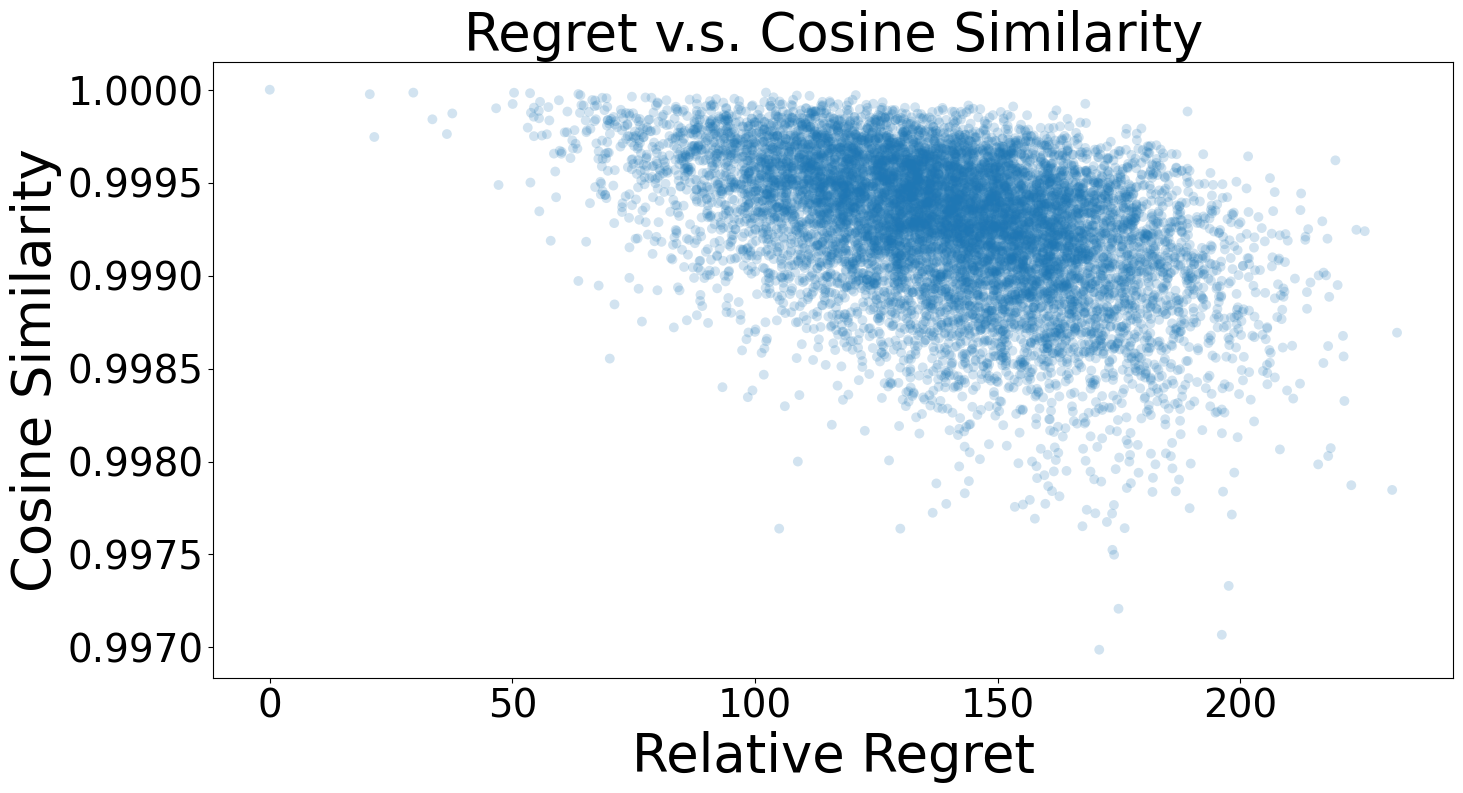

In [10]:
from matplotlib import pyplot as plt
# set fig
fig = plt.figure(figsize=(16,8))
plt.scatter(regrets, cos_sims, alpha=0.2, s=50, edgecolors="none")
plt.xlabel("Relative Regret", fontsize=38)
plt.ylabel("Cosine Similarity", fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
# title
plt.title("Regret v.s. Cosine Similarity", fontsize=38)
# save
plt.savefig("./images/regret_and_similarity.pdf")

## Pearson’s R

In [11]:
from scipy.stats import pearsonr

In [12]:
# calculate the coefficient of determination (R^2)
res = pearsonr(regrets, cos_sims, alternative="less")
print("Pearson’s R: {:.2f}".format(res.statistic))
print("P Value: {}".format(res.pvalue))

Pearson’s R: -0.44
P Value: 0.0


### Log Regret

In [13]:
# calculate the coefficient of determination (R^2)
res = pearsonr(np.log(regrets[regrets > 1e-5]), cos_sims[regrets > 1e-5], alternative="less")
print("Pearson’s R: {:.2f}".format(res.statistic))
print("P Value: {}".format(res.pvalue))

Pearson’s R: -0.43
P Value: 0.0


### Log Similarity

In [14]:
# calculate the coefficient of determination (R^2)
res = pearsonr(regrets, np.log(cos_sims), alternative="less")
print("Pearson’s R: {:.2f}".format(res.statistic))
print("P Value: {}".format(res.pvalue))

Pearson’s R: -0.44
P Value: 0.0
